In [1]:
# 時刻を0時00分からの経過分数に変える関数
def clock_time_to_passed_minutes(t):
    hr=float(t[:2])
    min=float(t[2:])
    return(hr*60+min)

# 最大利用時間を求める関数
def available_time(depart,arrive,start,end,travel_time_1,travel_time_2):
    depart_time = clock_time_to_passed_minutes(depart) # アンカーを出発する（最も遅い）時刻
    arrive_time = clock_time_to_passed_minutes(arrive) # アンカーに到着する必要がある時刻
    start_time = clock_time_to_passed_minutes(start) # 施設運営開始時刻
    end_time = clock_time_to_passed_minutes(end) # 施設運営終了時刻
    
    # （最も早い）施設滞在開始時刻の計算
    # travel_time_1が出発アンカーから施設までの移動時間、travel_time_2が施設から到着アンカーまでの移動時間
    t = depart_time + travel_time_1
    if t > start_time:
        available_start = t
    else:
        available_start = start_time
    
    # （最も遅い）施設滞在終了時刻の計算
    t = arrive_time - travel_time_2
    if t < end_time:
        available_end = t
    else:
        available_end = end_time
    
    return(available_end - available_start)

# 物理的滞在可能時間を求める関数
def physical_stay_time(depart,arrive,travel_time_1,travel_time_2):
    depart_time = clock_time_to_passed_minutes(depart) # アンカーを出発する（最も遅い）時刻
    arrive_time = clock_time_to_passed_minutes(arrive) # アンカーに到着する必要がある時刻
    return((arrive_time - travel_time_2)-(depart_time + travel_time_1))
    


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import osmnx as ox
import geopandas as gpd
import networkx as nx


In [3]:
# 歩行経路ネットワークデータのダウンロード
road_extent = gpd.read_file("data/1200m_buff.shp")
road_extent_wgs84 = road_extent.to_crs(4326)
road_wgs84 = ox.graph_from_polygon(road_extent_wgs84.unary_union,network_type="walk")
road = ox.project_graph(road_wgs84,to_crs=6678)

In [4]:
# 分速80mとして、移動時間を計算
for key in road.edges:
    road.edges[key]["time_dist"]=road.edges[key]["length"]/80

In [5]:
# すべてのノードのIDのリストの作成
node_ids = []
for key in road.nodes:
    node_ids.append(key)

In [6]:
# 評価対象範囲内のノードのみ
eval_extent = gpd.read_file("data/1000m_buff.shp")
nodes_gdf, edges_gdf = ox.graph_to_gdfs(road)
nodes_gdf_eval = gpd.clip(nodes_gdf,eval_extent)
# nodes_gdf_eval.indexとすることで、評価対象範囲内のノードの一覧を取ることができる

In [7]:
dentists_gdf = gpd.read_file("data/dentists_within_1200m_radius.shp")

In [8]:
# 施設（歯科医）の座標値のリスト作成
dentist_coords=[]
for dentist in dentists_gdf["geometry"]:
    dentist_coords.append((dentist.x,dentist.y))

In [9]:
time_from_dentist_to_node = {}
for node_id in node_ids:
    time_from_dentist_to_node[node_id]=[]

# すべての施設（歯科医）から全てのノードまでの移動時間を計算、最寄りノードのidのリストの作成
dentist_node_ids =[]

for i in range(len(dentist_coords)):
    source_id = ox.nearest_nodes(road,dentist_coords[i][0],dentist_coords[i][1])
    dentist_node_ids.append(source_id)
    time_from_source = nx.single_source_dijkstra_path_length(road,source=source_id,weight="time_dist")
    for j in time_from_source:
        time_from_dentist_to_node[j].append(time_from_source[j])

In [10]:
# 大学から全てのノードまでの移動時間の計算
univ_gdf = gpd.read_file("data/university.shp")
univ_node_id = ox.nearest_nodes(road,univ_gdf.iloc[0,1].x,univ_gdf.iloc[0,1].y)
time_from_univ_to_node = nx.single_source_dijkstra_path_length(road,source=univ_node_id,weight="time_dist")

In [11]:
# 施設運営時間（歯科医診療時間）データの読み込み
open_hour_df = pd.read_excel("data/opening_hour.xlsx",dtype=str)

In [12]:
n_dentists=len(dentist_node_ids)

depart_time_from_univ="1730"
arrive_time_to_home="2000"
min_duration=30

n_reachable_list =[]
n_above_min_duration_list = []
total_duration_list = []

for i in nodes_gdf_eval.index:
    t0 = time_from_univ_to_node[i]
    
    n_reachable=0
    n_above_min_duration=0
    total_duration=0
    
    for j,t1 in zip(range(n_dentists),time_from_dentist_to_node[univ_node_id]):
        t2=time_from_dentist_to_node[i][j]
        # t2+t1-t0が迂回（時間）距離になる
        if physical_stay_time(depart_time_from_univ,arrive_time_to_home,t1,t2)>0 and t1+t2-t0 <5:
            n_reachable += 1
            start_time=open_hour_df.iloc[j,7] # 水曜日について計算しているため、列番号が7となっている。他の曜日について計算する場合にはここを変更
            end_time=open_hour_df.iloc[j,8] # 上の行と同様
            duration = available_time(depart_time_from_univ,arrive_time_to_home,start_time,end_time,t1,t2)
            if duration > min_duration:
                n_above_min_duration += 1
                total_duration = total_duration + duration
    
    n_reachable_list.append(n_reachable)
    n_above_min_duration_list.append(n_above_min_duration)
    total_duration_list.append(total_duration)

In [13]:
nodes_gdf_eval["n_reachable"]=n_reachable_list
nodes_gdf_eval["n_above_min_duration"]=n_above_min_duration_list
nodes_gdf_eval["total_duration"]=total_duration_list

/Users/atsushi/.pyenv/versions/miniforge3-4.10.3-10/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/atsushi/.pyenv/versions/miniforge3-4.10.3-10/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/atsushi/.pyenv/versions/miniforge3-4.10.3-10/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarni

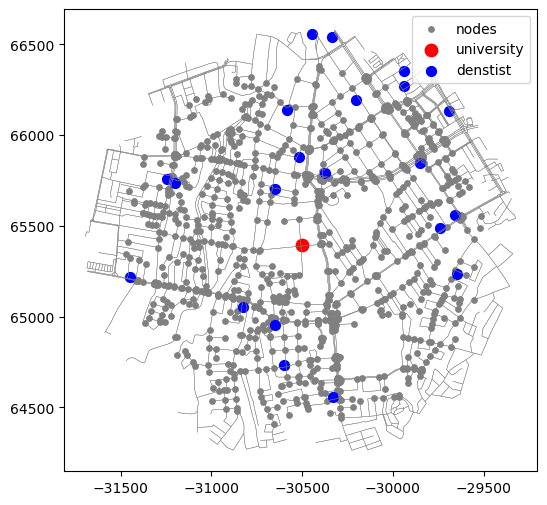

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
edges_gdf.plot(ax=ax,linewidth=0.3,color="grey")
nodes_gdf_eval.plot(ax=ax,color="grey",markersize=15,label='nodes')
univ_gdf.plot(ax=ax,color="red",markersize=80,label='university')
dentists_gdf.plot(ax=ax,color="blue",markersize=50,label='denstist')
plt.legend()

fig.savefig("study_area.png")

In [15]:
from matplotlib.font_manager import FontProperties
fp=FontProperties(fname=r'/Library/Fonts/Arial Unicode.ttf')

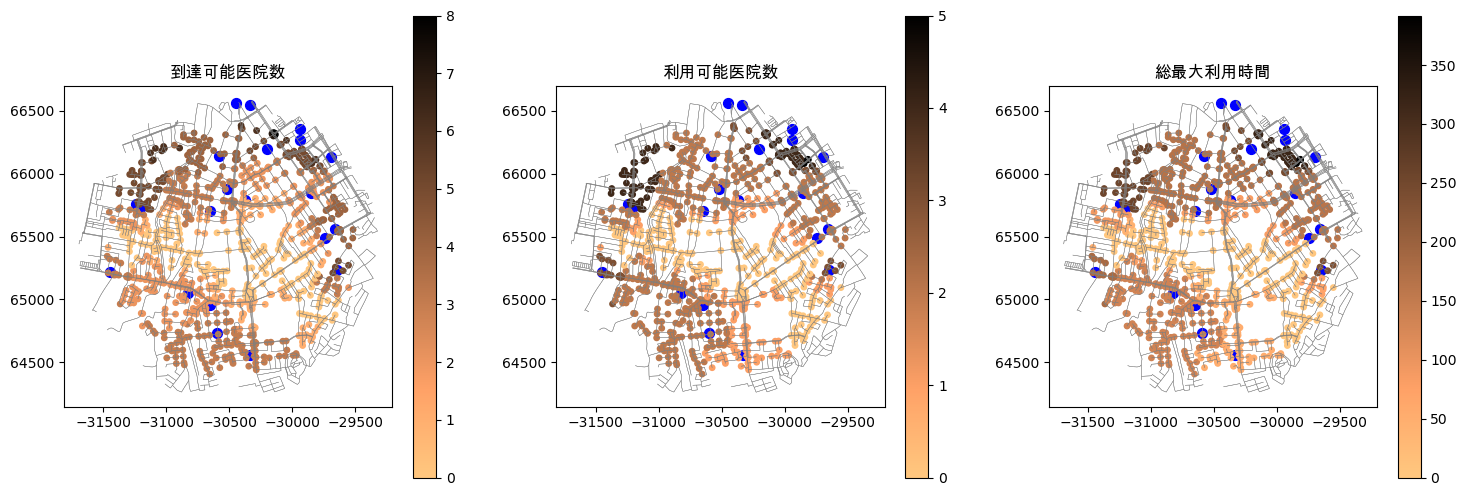

In [16]:
fig, ax = plt.subplots(1,3,figsize=(18,6))
stams_visualized=["n_reachable","n_above_min_duration","total_duration"]
titles=["到達可能医院数","利用可能医院数","総最大利用時間"]
for i in range(3):
    ax[i].set_title(titles[i],fontproperties=fp,fontsize=12)
    edges_gdf.plot(ax=ax[i],linewidth=0.3,color="grey")
    dentists_gdf.plot(ax=ax[i],color="blue",label='dentist',markersize=50)
    nodes_gdf_eval.plot(ax=ax[i],markersize=15,column=stams_visualized[i],cmap="copper_r",legend=True)

fig.savefig("stams.png")

In [17]:
nodes_gdf_eval["diff"]=nodes_gdf_eval.apply(lambda x:x["n_reachable"]-x["n_above_min_duration"],axis=1)

/Users/atsushi/.pyenv/versions/miniforge3-4.10.3-10/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


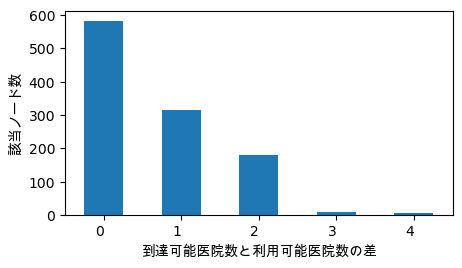

In [18]:
fig,ax=plt.subplots(figsize=(5,3))
nodes_gdf_eval["diff"].value_counts().plot.bar(ax=ax)
fig.autofmt_xdate(rotation=0)
plt.xlabel("到達可能医院数と利用可能医院数の差",fontproperties=fp)
plt.ylabel("該当ノード数",fontproperties=fp)

fig.savefig("hist.png")

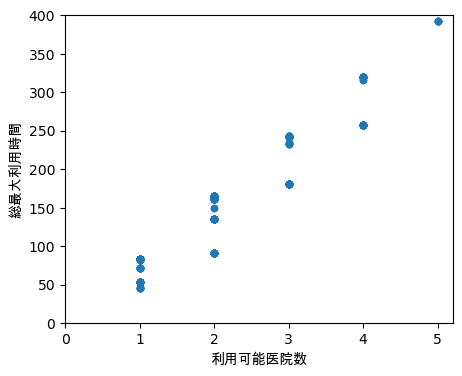

In [19]:
nodes_gdf_eval_subset = nodes_gdf_eval.query('n_above_min_duration > 0').copy()
fig,ax=plt.subplots(figsize=(5,4))
nodes_gdf_eval_subset.plot.scatter(ax=ax,x='n_above_min_duration',y='total_duration',
                                   xlim=[0,5.2],ylim=[0,400],xticks=[0,1,2,3,4,5])
plt.xlabel("利用可能医院数",fontproperties=fp)
plt.ylabel("総最大利用時間",fontproperties=fp)

fig.savefig("scatter_plot.png")

In [20]:
from scipy import stats
stats.pearsonr(nodes_gdf_eval_subset["n_above_min_duration"],nodes_gdf_eval_subset["total_duration"])

PearsonRResult(statistic=0.9551812488838897, pvalue=0.0)

In [21]:
nodes_gdf_eval_subset[nodes_gdf_eval_subset["n_above_min_duration"]==2].describe()

,y,x,street_count,lon,lat,n_reachable,n_above_min_duration,total_duration,diff
count,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.0,484.000000,484.000000
mean,65512.601081,-30540.411227,2.886364,140.472535,40.589485,2.733471,2.0,150.065754,0.733471
std,500.179541,496.490335,0.974573,0.005856,0.004511,0.754034,0.0,18.642855,0.754034
min,64408.184801,-31451.982222,1.000000,140.461757,40.579534,2.000000,2.0,91.473537,0.000000
25%,65063.820069,-30894.352296,3.000000,140.468377,40.585421,2.000000,2.0,134.649163,0.000000
50%,65696.684353,-30665.919015,3.000000,140.471063,40.591137,3.000000,2.0,161.608350,1.000000
75%,65918.983197,-30201.646067,3.000000,140.476516,40.593141,3.000000,2.0,165.690675,1.000000
max,66321.878247,-29517.142794,5.000000,140.484621,40.596764,4.000000,2.0,165.690675,2.000000
